<a href="https://colab.research.google.com/github/Tommy-Las/WatfordFC/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#file_path = '/content/drive/MyDrive/WATFORD FC/Datos GPS/datos_finales_tommy.xlsx'
#file_path = '/content/drive/MyDrive/WATFORD FC/Datos GPS/datos_finales_tommy2.xlsx'
#file_path = 'datos_finales_tommy.xlsx'
#file_path = 'data/cleaned_data.xlsx'
file_path = 'data/cleaned_data_no_injured.xlsx'
# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
print(df.head())

        DATE Microcycle  Injury preseason-season      TD    HSR  +25 Km/h  \
0 2021-08-11        M-3       0           SEASON  7423.0  426.0        20   
1 2021-08-12        M-2       0           SEASON  1268.0    0.0         0   
2 2021-08-13        M-1       0           SEASON  4135.0  112.0         2   
3 2021-08-15        M+1       0           SEASON  6379.0   86.0         0   
4 2021-08-17        M-4       0           SEASON  6287.0  209.0         9   

    ACC   DEC  PlayerID  ...  +25 Km/h_ACWR  +25 Km/h_MSWR  ACC_ACWR  \
0  52.0  38.0     23085  ...       1.000000       2.727412  1.000000   
1  11.0   5.0     23085  ...       1.000000       1.053370  1.000000   
2  47.0  20.0     23085  ...       1.000000       0.870478  1.000000   
3  49.0  48.0     23085  ...       1.000000       0.647982  1.000000   
4  62.0  44.0     23085  ...       0.545055       0.581739  0.889336   

   ACC_MSWR  DEC_ACWR   DEC_MSWR  Injury_7_day  Category  Category_MATCH  \
0  7.392480   1.00000  26.16

Chequear desbalanceo de clases

In [4]:
print("No Lesión: " + str(df[df["Injury_7_day"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury_7_day"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury_7_day'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 3942
Lesión: 197
Porcentaje de lesionados en el dataset: 4.76%


# Initialize metrics

In [5]:
metrics = ['TD', 'HSR',
       '+25 Km/h', 'ACC', 'DEC', 'Sprints', '% Max Speed']

# Correlation of variables

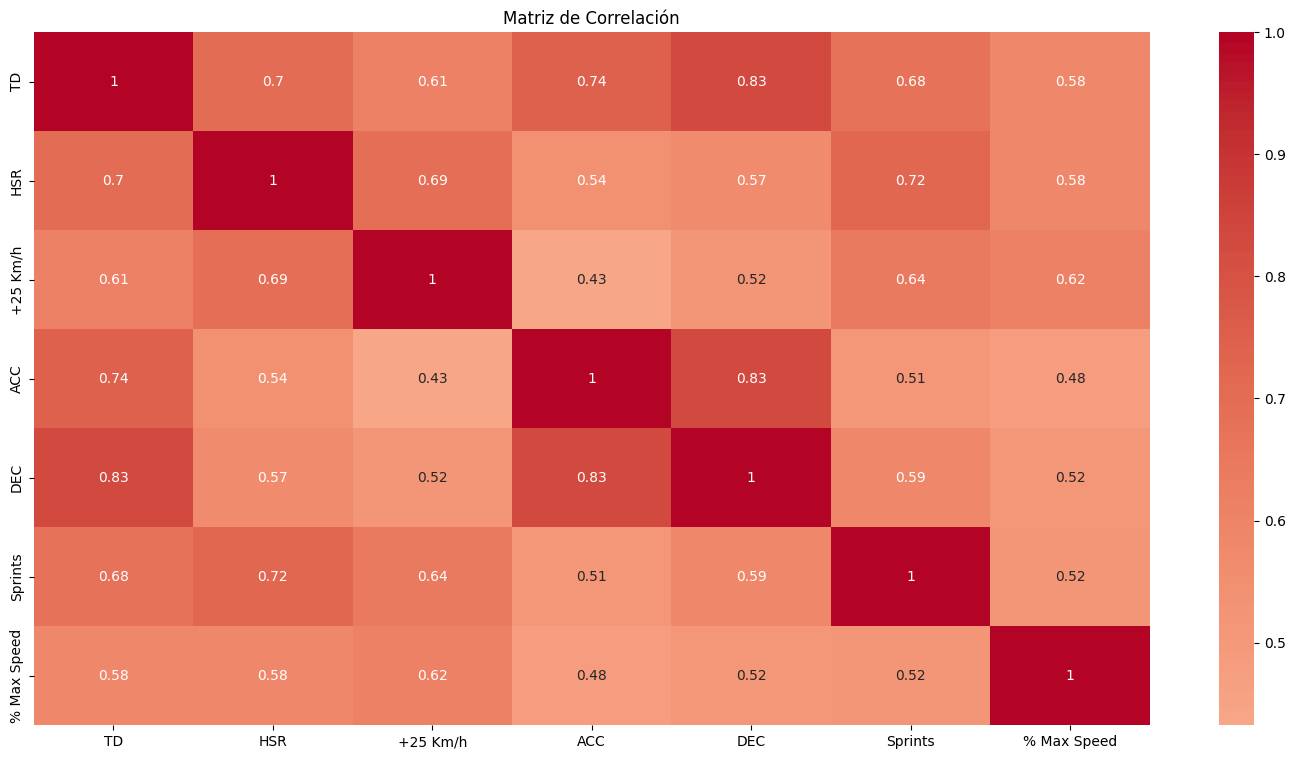

In [113]:
# Calcular la matriz de correlación
correlation_matrix = df[metrics].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [114]:
df_with_constant = add_constant(df[metrics])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

      Variable        VIF
0        const  68.786842
1           TD   4.574959
2          HSR   2.948752
3     +25 Km/h   2.408087
4          ACC   3.431651
5          DEC   4.917893
6      Sprints   2.527502
7  % Max Speed   1.867356


# ML Modelos

## Separate data into X, y and player_ids

In [17]:
df.columns

Index(['DATE', 'Microcycle', 'Injury', 'preseason-season', 'TD', 'HSR',
       '+25 Km/h', 'ACC', 'DEC', 'PlayerID', 'Max Speed', 'Sprints', 'Mins',
       'Max Speed Season', 'Avg Speed Season', '% Max Speed',
       'Speed Diff Max Avg', 'TD_Rel', 'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel',
       'DEC_Rel', 'TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7',
       '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7',
       'Sprints-7', 'Mins-7', 'Mins-7-avg', 'Mins-7-std', 'Mins_EWMA-7',
       'Mins-28', 'Mins-28-avg', 'Mins-28-std', 'Mins_EWMA-28', 'TD_ACWR',
       'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR', '+25 Km/h_ACWR', '+25 Km/h_MSWR',
       'ACC_ACWR', 'ACC_MSWR', 'DEC_ACWR', 'DEC_MSWR', 'Injury_7_day',
       'Category', 'Category_MATCH', 'Category_TRAINING'],
      dtype='object')

In [5]:
# metrics = ['TD', 'HSR','+25 Km/h', 'ACC', 'DEC', 'Max Speed', 'Sprints', 'Mins',
#        'Max Speed Season', 'Avg Speed Season', '% Max Speed',
#        'Speed Diff Max Avg', 'TD_Rel', 'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel',
#        'DEC_Rel', 'TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7',
#        '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7',
#        'Sprints-7', 'Mins-7', 'Mins-7-avg', 'Mins-7-std', 'Mins_EWMA-7',
#        'Mins-28', 'Mins-28-avg', 'Mins-28-std', 'Mins_EWMA-28', 'TD_ACWR',
#        'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR', '+25 Km/h_ACWR', '+25 Km/h_MSWR',
#        'ACC_ACWR', 'ACC_MSWR', 'DEC_ACWR', 'DEC_MSWR', 'Injury_7_day', 'Category_MATCH', 'Category_TRAINING']

# metrics = ['TD', 'HSR',
#        '+25 Km/h', 'ACC', 'DEC', 'Sprints', '% Max Speed', 'TD_Rel', 'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel',
#        'DEC_Rel','TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'DEC-7',
#        'Sprints-7']

# metrics = ['TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'DEC-7',
#        'Sprints-7','Mins-7','Category_MATCH',
#        'Category_TRAINING']

# metrics = ['TD', 'HSR',
#        '+25 Km/h', 'ACC', 'DEC', 'Sprints', 'Mins', '% Max Speed', 'TD_Rel', 'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel',
#        'DEC_Rel', 'TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7',
#        '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7',
#        'Sprints-7', 'Mins-7', 'TD_ACWR', 'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR', '+25 Km/h_ACWR', '+25 Km/h_MSWR',
#        'ACC_ACWR', 'DEC_ACWR', 'Category_MATCH', 'Category_TRAINING']

# metrics = ['TD', 'HSR',
#        '+25 Km/h', 'ACC', 'DEC', 'Sprints', 'Mins', '% Max Speed', 'TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7',
#        '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7',
#        'Sprints-7', 'Mins-7', 'TD_ACWR', 'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR', '+25 Km/h_ACWR', '+25 Km/h_MSWR',
#        'ACC_ACWR', 'DEC_ACWR', 'Category_MATCH', 'Category_TRAINING']

metrics = ['TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7',
       '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7',
       'Sprints-7', 'Mins-7', 'TD_ACWR', 'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR', '+25 Km/h_ACWR', '+25 Km/h_MSWR',
       'ACC_ACWR', 'DEC_ACWR']

# metrics = ['TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'DEC-7','Sprints-7','Mins-7']

# metrics = ['TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7',
#        '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7',
#        'Sprints-7', 'TD_ACWR', 'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR',
#        '+25 Km/h_ACWR', '+25 Km/h_MSWR', 'ACC_ACWR', 'DEC_ACWR']

print(len(metrics))

20


In [6]:
player_ids = df['PlayerID']
X = df[metrics]
y = df['Injury_7_day']

## Feature Engineering

In [176]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def mrmr_manual_regression(X, y, num_features):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    
    # Calculate mutual information for relevance (regression)
    relevance = mutual_info_regression(X, y)
    
    for _ in range(num_features):
        scores = []
        for feature in remaining_features:
            # Calculate redundancy with already selected features
            redundancy = np.mean([mutual_info_regression(X[:, feature].reshape(-1, 1), X[:, sel]) 
                                  for sel in selected_features]) if selected_features else 0
            
            # mRMR score = relevance - redundancy
            score = relevance[feature] - redundancy
            scores.append((feature, score))
        
        # Select the feature with the maximum score
        best_feature = max(scores, key=lambda x: x[1])[0]
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    
    return selected_features

selected_features_indexes = mrmr_manual_regression(X.values, y.values, 20)

feature_names = X.columns  # Assuming X is a pandas DataFrame
selected_feature_names = [feature_names[i] for i in selected_features_indexes]

print("Selected Features:", selected_feature_names)

X = X[selected_feature_names]

Selected Features: ['+25 Km/h_ACWR', 'Category_TRAINING', 'ACC', 'HSR_MSWR', 'HSR_EWMA-7', '% Max Speed', 'DEC-7', 'Category_MATCH', 'ACC_ACWR', 'Sprints-7', '+25 Km/h_EWMA-7', 'TD_MSWR', '+25 Km/h_MSWR', 'DEC', 'Sprints', 'HSR_ACWR', 'ACC_EWMA-7', '+25 Km/h', 'TD-7', 'TD']


**Feature Selection**

Removes features with low variance

In [79]:
# Initialize VarianceThreshold with a threshold
vt = VarianceThreshold(threshold=0.01)  # Removes features with variance < 0.01

# Apply VarianceThreshold to the entire dataset (X)
X_reduced = vt.fit_transform(X)  # Retains only high-variance features

# Get selected feature names (if X is a DataFrame)
removed_features = X.columns[~vt.get_support()]
print("Removed Features:", removed_features)

Removed Features: Index([], dtype='object')


Based on the response , there is no columns that need to be removed

## SMOTE Technique

In [7]:
# Split the data into training and test sets (test set remains untouched)
X_train, X_test, y_train, y_test, player_ids_train, player_ids_test = train_test_split(X, y, player_ids, test_size=0.2, random_state=42, stratify=y)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train , y_train = smote.fit_resample(X_train, y_train)

# smote_enn = SMOTEENN(random_state=42)
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury_7_day
0    3153
1    3153
Name: count, dtype: int64
Injury_7_day
0    3153
1    3153
Name: count, dtype: int64


## SVM

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      1338
           1       0.08      0.59      0.15        39

    accuracy                           0.81      1377
   macro avg       0.53      0.70      0.52      1377
weighted avg       0.96      0.81      0.87      1377

Test Set AUC: 0.812847341995324


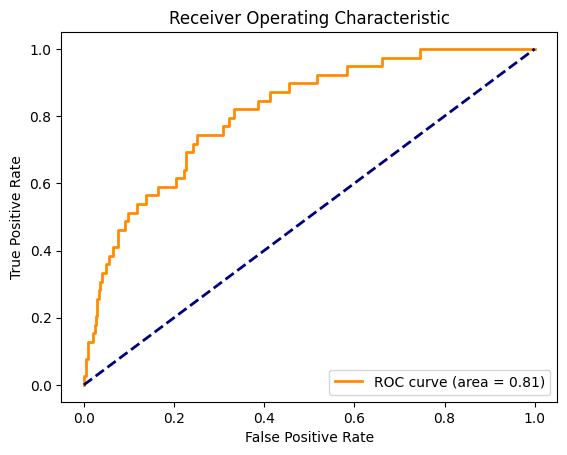

In [184]:
# Split data into train/validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

# SMOTE for oversampling the training data
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_val_scaled, y_train_val)

# Train the SVM model
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred = svm_model.predict(X_test_scaled)
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

# Plot ROC Curve (optional)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## XGBoost Model

Perform Recursive Feature Elimination with Cross-Validation (RFECV) to find the best variables

Use GridSearch to find the best hyperparameters

In [8]:
# Base parameters for XGBClassifier
base_params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.8,  # Feature subsampling
    'subsample': 0.8,         # Row subsampling
    'eval_metric': 'auc',
    'alpha': 5,              # L1 regularization
    'gamma': 5,              # Minimum loss reduction
    'max_depth': 3,
    'learning_rate': 0.09,
    'n_estimators': 100
}

# Initialize the XGBClassifier
rfe_model = XGBClassifier(**base_params)

# Perform RFE for feature selection
rfe = RFE(
    estimator=rfe_model,
    n_features_to_select=36,  # Select exactly X features
    step=1  # Remove one feature at a time
)

# Fit RFE to X_train
rfe.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected Features (RFE): {selected_features.tolist()}")
print(f"Number of features selected: {len(selected_features)}")

Selected Features (RFE): ['TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7', '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7', 'Sprints-7', 'Mins-7', 'TD_ACWR', 'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR', '+25 Km/h_ACWR', '+25 Km/h_MSWR', 'ACC_ACWR', 'DEC_ACWR']
Number of features selected: 20


/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=36 > n_features=20. There will be no feature selection and all features will be kept.
  warnings.warn(


In [9]:
# Updated base parameters with added regularization
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

# Expanded parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [10, 12,15],
    'alpha': [0, 1, 5, 10],
    'gamma': [0, 1, 5, 10],
}

# scaler = StandardScaler()
# X_train_selected = scaler.fit_transform(X_train_selected)
# X_test_selected = scaler.transform(X_test_selected)

model = XGBClassifier(**base_params_xgboost)

# Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for ROC-AUC
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training dataset
grid_search.fit(X_train_selected, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print best results
print(f"Best ROC-AUC (Grid Search): {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best ROC-AUC (Grid Search): 0.9973
Best Parameters: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 15}


## Train the model with the best parameters and add early stopping

In [41]:
# Final Test ROC-AUC: 0.7218
# Accuracy: 0.7349
# Precision: 0.0618
# Recall: 0.5897
# param_grid = {
#     'learning_rate': 0.1,  # Explore smaller learning rates
#     'max_depth': 5,             # Test broader depth values
#     'n_estimators': 300,     # Include larger estimators
#     'scale_pos_weight': 9,
#     'alpha': 5,  # L1 regularization
#     'gamma': 5,  # Minimum loss reduction
# }

# Final Test ROC-AUC: 0.7883
# Accuracy: 0.7174
# Precision: 0.1146
# Recall: 0.7436
# F1 Score: 0.1986

# param_grid = {
#     'learning_rate': 0.07,  # Explore smaller learning rates
#     'max_depth': 7,             # Test broader depth values
#     'n_estimators': 400,     # Include larger estimators
#     'scale_pos_weight': 14,
#     'alpha': 5,  # L1 regularization
#     'gamma': 5,  # Minimum loss reduction
# }


param_grid = {
    'learning_rate': 0.07,  # Explore smaller learning rates
    'max_depth': 7,             # Test broader depth values
    'n_estimators': 400,     # Include larger estimators
    'scale_pos_weight': 14,
    'alpha': 5,  # L1 regularization
    'gamma': 5,  # Minimum loss reduction
}


# Train the final model
final_model = XGBClassifier(
    **base_params_xgboost,
    **param_grid,
)

# Train
final_model.fit(X_train_selected,
                y_train,
                verbose=True
)

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test_selected)[:, 1]
# Apply custom threshold
threshold = 0.40
y_pred = (y_pred_probs >= threshold).astype(int)
test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Final Test ROC-AUC: 0.7883
Accuracy: 0.6558
Precision: 0.1006
Recall: 0.7949
F1 Score: 0.1787
Confusion Matrix:
[[512 277]
 [  8  31]]


## Transform test data

In [32]:
X_test = X_test_selected.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
player_ids_test = player_ids_test.reset_index(drop=True)

In [33]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Evaluate the best model on the test set
y_probs = final_model.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_probs)

print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage = y_probs * 100

# Categorize the injury risk percentages
risk_levels = [categorize_risk(percentage) for percentage in injury_risk_percentage]

# Create the `results` DataFrame with only relevant metrics and calculated values
results = pd.DataFrame({
    'Player_ID': player_ids_test,  # Add player IDs
    'Actual_Label': y_test,  # Add actual labels
    '%': injury_risk_percentage,
    'Risk_Level': risk_levels
}).join(X_test[['TD-7', '+25 Km/h-7', 'ACC-7', 'DEC-7', 'Sprints-7']])  # Add only relevant metrics



Test ROC-AUC: 0.7883


In [34]:
# Define risk level colors
color_mapping = {
    'High Risk': 'FF9999',  # Light Red
    'Medium Risk': 'FFFF99',  # Light Yellow
    'Low Risk': '99FF99'  # Light Green
}

# file_path_export = '/content/drive/MyDrive/WATFORD FC/Datos GPS/results.xlsx'
file_path_export = 'results.xlsx'

wb = Workbook()

# Write `results` to the first sheet
ws = wb.active
ws.title = "Injury Risk Results"
for r_idx, row in enumerate(dataframe_to_rows(results, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results`
risk_level_col_idx = list(results.columns).index("Risk_Level") + 2
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=risk_level_col_idx, max_col=risk_level_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Save the workbook
wb.save(file_path_export)